Paper:
https://arxiv.org/pdf/1512.04150.pdf

GitHub:
https://github.com/jacobgil/keras-cam

In [1]:
import glob
import os, sys
import numpy as np
import scipy

import cv2
import skimage
import matplotlib.pyplot as plt
from keras.preprocessing import image as kimage

plt.style.use('ggplot')
%matplotlib inline
sys.path.insert(0,'..') # add parent directory to path

import keras
from keras.utils.np_utils import to_categorical
import h5py

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.models import *
from keras.callbacks import *
import keras.backend as K

from sklearn.model_selection import train_test_split

import utils
import core_models
import poet_file_manager

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
img_width = 224
img_size = (img_width, img_width)
img_shape = (img_width, img_width, 3)

In [3]:
train_ids, test_ids = utils.load_object('../train_ids.pkl'), utils.load_object('../test_ids.pkl')

In [4]:
def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))

def global_average_pooling_shape(input_shape):
    return input_shape[2:4]

def get_model(out_classes, img_shape, mode='vgg'):
    
    if mode=='vgg':
        model = core_models.VGG16_convolutions(img_shape=img_shape)
        model = load_model_weights(model, "./vgg.h5")

    #     model = resnet()
        for layer in model.layers[:]:
            layer.trainable = False
    
    if mode=='other':
        model = core_models.other_model(img_shape)
        
    # Rename last conv layer to later access it for CAM
    model.layers[-1].name = 'last_conv'
    
    # There cannot be any other layer in between the Dense and Global Average Pooling
    # due to how class activations are generated
    model.add(Lambda(global_average_pooling, 
              output_shape=global_average_pooling_shape))
    model.add(Dense(out_classes, activation = 'softmax'))

    optm = Adam()
    model.compile(loss = 'categorical_crossentropy', optimizer = optm, metrics=['accuracy'])
    
    print(model.summary())
    for layer in model.layers:
        print(layer.name, layer.trainable)
    return model

def load_model_weights(model, weights_path):
    print('Loading model.')

    model.load_weights(weights_path)

    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [5]:
def print_proba_results(proba_res, inv_class_map):
    for i, proba in enumerate(proba_res):
        print(inv_class_map[proba[0]], proba[1])

def visualize_class_activation_map(model, original_img, output_path, class_map, 
                                   visualize_for_class=None, cam_thresh=0.4):
    # adapted from https://github.com/jacobgil/keras-cam
    # visualize_for_class_n decides for which class the CAM should be plotted
    inv_class_map = {value: key for key, value in class_map.items()}
    
#     model = load_model(model_path)
    width, height, _ = original_img.shape

    img = np.array([np.float32(original_img)])

    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "last_conv")
    
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    proba_res = [(i, proba) for i, proba in enumerate(predictions[0])]
    proba_res.sort(key= lambda pair: pair[1], reverse=True)
#     print(proba_res)
    for i, proba in enumerate(proba_res):
        print(inv_class_map[proba[0]], proba[1])
        if i == 1:
            second_class_n = proba[0]
    
    conv_outputs = conv_outputs[0, :, :, :]
#     print('class weights:', class_weights.shape)
    
    if visualize_for_class == 'second':
        visualize_for_class = second_class_n
    elif type(visualize_for_class) == str:
        visualize_for_class = class_map[visualize_for_class]
    
    # visualize the maximum prob class if no class was specified in arguments
    if visualize_for_class is None:
        class_n = np.argmax(predictions)
    else:
        class_n = visualize_for_class
        
    print("Visualizing for", inv_class_map[class_n])
    print("Prediction", inv_class_map[np.argmax(predictions)])

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_n]):
        cam += w * conv_outputs[:, :, i]
    
#     cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
#     cam = utils.normalize(cam)
    
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    if cam_thresh is not None:
        heatmap[np.where(cam < cam_thresh)] = 0
    
    img = (heatmap*0.5 + original_img)
    img /= np.max(img)
    
    plt.imshow(img)
    plt.grid(False)
#     plt.show()
    return cam, proba_res
#     cv2.imwrite(output_path, img)
#     cv2.imshow('test', img)

In [6]:
train_0 = [el.split('/')[-1] for el in glob.glob('./train/0/*')]
test_0 = [el.split('/')[-1] for el in glob.glob('./test/0/*')]

In [7]:
len(train_0), len(test_0)

(599, 67)

In [8]:
np.sum([el in train_0 for el in test_0]) # check that test and train are disjoint

0

In [9]:
epochs_n = 200
batch_size = 32

if not os.path.exists('./weights'):
    os.makedirs('./weights')
checkpoint_path="./weights/vggweights.{epoch:02d}-{val_loss:.2f}.hdf5"

train_data_dir = './train/'
test_data_dir = './test/'

train_datagen = ImageDataGenerator(
                                   horizontal_flip=False
                                )

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

X_test, y_test, class_map, names = poet_file_manager.load_poet(img_size, test_ids)

Found 5517 images belonging to 10 classes.
Loading POET dataset...
aeroplane* 0
boat* 1
dog* 2
bicycle* 3
cat* 4
cow* 5
diningtable* 6
horse* 7
motorbike* 8
sofa* 9
X.shape: (614, 224, 224, 3) y.shape: (614,)
Loaded POET dataset.


In [10]:
class_map

{'aeroplane': 0,
 'boat': 1,
 'dog': 2,
 'bicycle': 3,
 'cat': 4,
 'cow': 5,
 'diningtable': 6,
 'horse': 7,
 'motorbike': 8,
 'sofa': 9}

In [62]:
model = get_model(out_classes=10, img_shape=img_shape, mode='vgg')

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
  model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
  mod

Loading model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_92 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_93 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_94 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856 

In [63]:
print("Training..")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.005, mode='min', verbose=10, restore_best_weights=True)

history = model.fit_generator(train_generator, epochs=epochs_n, callbacks=[checkpoint, earlystopping], validation_data=(X_test, y_test),
                             steps_per_epoch = len(train_generator.filenames) // batch_size)

Training..
Epoch 1/200
172/172 [==============================] - 27s 156ms/step - loss: 2.3582 - acc: 0.4881 - val_loss: 1.3047 - val_acc: 0.6466
Epoch 2/200
172/172 [==============================] - 26s 153ms/step - loss: 0.9848 - acc: 0.7128 - val_loss: 0.9884 - val_acc: 0.7117
Epoch 3/200
172/172 [==============================] - 26s 153ms/step - loss: 0.7504 - acc: 0.7699 - val_loss: 0.8612 - val_acc: 0.7427
Epoch 4/200
172/172 [==============================] - 26s 154ms/step - loss: 0.6201 - acc: 0.8022 - val_loss: 0.7756 - val_acc: 0.7459
Epoch 5/200
172/172 [==============================] - 26s 154ms/step - loss: 0.5330 - acc: 0.8305 - val_loss: 0.7551 - val_acc: 0.7622
Epoch 6/200
172/172 [==============================] - 26s 153ms/step - loss: 0.4702 - acc: 0.8442 - val_loss: 0.7229 - val_acc: 0.7818
Epoch 7/200
172/172 [==============================] - 26s 154ms/step - loss: 0.4257 - acc: 0.8578 - val_loss: 0.7126 - val_acc: 0.7752
Epoch 8/200
172/172 [================

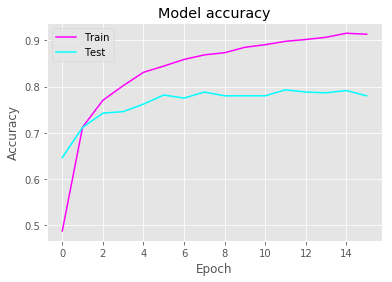

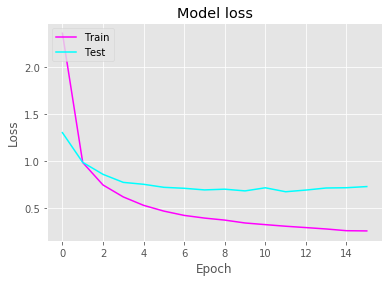

In [65]:
utils.plot_history(history)

In [159]:
inv_class_map = inv_map = {v: k for k, v in class_map.items()}
model_path = './weights/vggweights.12-0.68.hdf5'

In [160]:
model = load_model(model_path)
y_pred = model.predict(X_test)

In [161]:
np.mean(np.argmax(y_test, 1) == np.argmax(y_pred, 1))

0.7931596091205212

Normalized confusion matrix


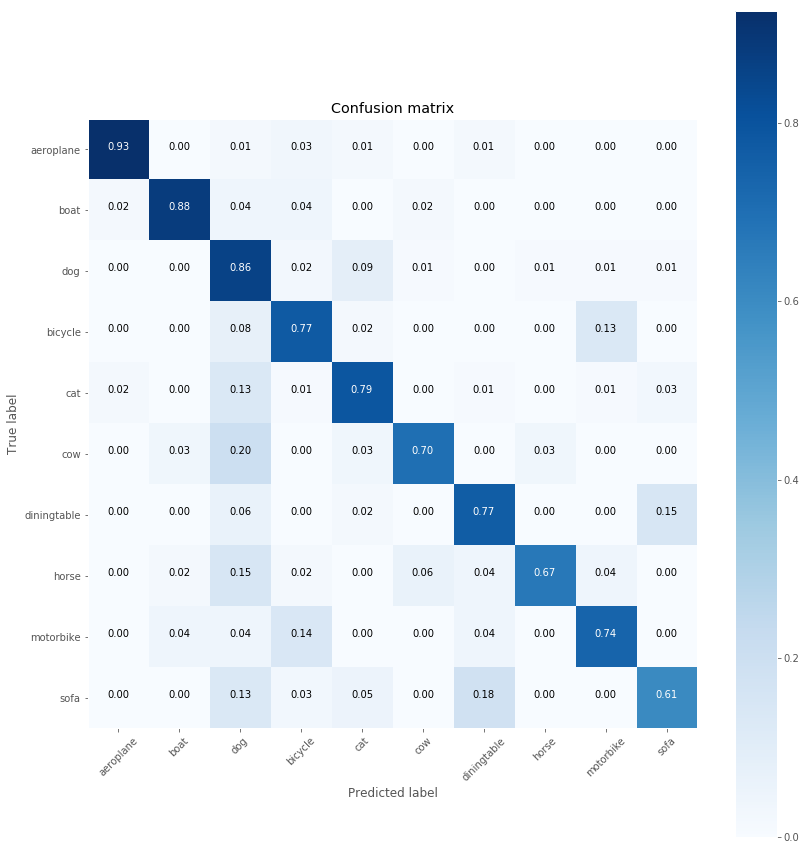

In [162]:
plt.figure(figsize=(12,12))
fig = utils.plot_confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1), class_map.keys(), normalize=True)

In [163]:
mistakes_mask = np.argmax(y_test, 1) != np.argmax(y_pred, 1)
print(np.mean(np.logical_not(mistakes_mask)))
mistakes_names = names[mistakes_mask]
correct_names = names[np.logical_not(mistakes_mask)]
print(len(mistakes_names))

0.7931596091205212
127


In [164]:
np.argmax(y_test, 1)[mistakes_mask], np.argmax(y_pred, 1)[mistakes_mask]

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([6, 2, 4, 3, 3, 3, 2, 2, 5, 0, 3, 4, 4, 8, 4, 4, 3, 4, 3, 4, 4, 3,
        4, 9, 7, 4, 4, 5, 4, 8, 8, 8, 8, 8, 2, 8, 2, 2, 4, 2, 8, 2, 0, 3,
        2, 2, 2, 9, 0, 2, 2, 2, 2, 2, 2, 8, 2, 2, 9, 6, 2, 9, 2, 2, 2, 2,
        7, 2, 2, 1, 2, 4, 2, 9, 9, 9, 4, 2, 9, 9, 2, 9, 9, 6, 2, 2, 5, 3,
        8, 5, 5, 2, 2, 2, 8, 2, 6, 1, 2, 3, 3, 2, 1, 1, 6, 2, 3, 6, 3, 3,
        3, 3, 3, 6, 2, 6, 4, 2, 2, 2, 4, 6, 6, 6, 6, 2, 6]))

In [165]:
# name = 'dog_2010_005149.jpg'
mistake_n = 5
name = mistakes_names[mistake_n]
print(name)
print(inv_class_map[np.argmax(y_pred, 1)[mistakes_mask][mistake_n]])
print(y_pred[mistakes_mask][mistake_n])
# image = X_test[mistakes_mask][mistake_n]

boat_2009_004786.jpg
bicycle
[2.2799679e-04 2.4541724e-01 1.9560216e-02 5.0273401e-01 6.2150028e-02
 1.0457919e-04 1.0824766e-06 3.0049073e-06 1.6980134e-01 5.1747793e-07]


In [166]:
def get_class(images, cat_labels, class_name):
    class_mask = np.argmax(cat_labels, 1) == class_map[class_name]
    return images[class_mask]

def get_image(images, file_names, image_name):
    index = list(file_names).index(image_name)
    return images[index]

get_image(X_test, names, name).shape, image.shape

((224, 224, 3), (224, 224, 3))

bicycle 0.50273275
boat 0.24541737
motorbike 0.16980247
cat 0.06215019
dog 0.019560043
aeroplane 0.00022799558
cow 0.00010458073
horse 3.0049341e-06
diningtable 1.0824924e-06
sofa 5.174732e-07
Visualizing for boat
Prediction bicycle
bicycle 0.50273275
boat 0.24541737
motorbike 0.16980247
cat 0.06215019
dog 0.019560043
aeroplane 0.00022799558
cow 0.00010458073
horse 3.0049341e-06
diningtable 1.0824924e-06
sofa 5.174732e-07
Visualizing for bicycle
Prediction bicycle


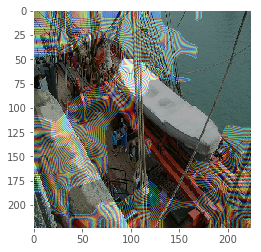

In [167]:
heatmap, org_img = visualize_class_activation_map(model=model, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.6,
                                    visualize_for_class=name.split('_')[0])

heatmap, org_img = visualize_class_activation_map(model=model, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.6,
                                    visualize_for_class=None)

In [168]:
org_img.shape

(224, 224, 3)

cow 0.90934
dog 0.08677049
cat 0.0038459362
horse 4.1650324e-05
diningtable 6.065648e-07
bicycle 4.1156056e-07
motorbike 3.376699e-07
boat 2.0023036e-07
aeroplane 1.4402424e-07
sofa 6.567445e-08
Visualizing for cow
Prediction cow


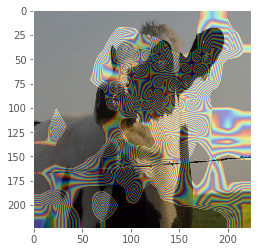

In [169]:
heatmap, org_img = visualize_class_activation_map(model=model, 
                                   original_img=get_class(X_test, y_test, 'cow')[10], 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.1)

In [170]:
# name = 'dog_2010_005149.jpg'

print(name)
print(inv_class_map[np.argmax(y_pred, 1)[mistakes_mask][mistake_n]])
print(y_pred[mistakes_mask][mistake_n])
# image = X_test[mistakes_mask][mistake_n]

boat_2009_004786.jpg
bicycle
[2.2799679e-04 2.4541724e-01 1.9560216e-02 5.0273401e-01 6.2150028e-02
 1.0457919e-04 1.0824766e-06 3.0049073e-06 1.6980134e-01 5.1747793e-07]


In [172]:
human_heatmaps = np.load('./heatmaps_resized.npy').tolist()

In [173]:
human_heatmaps_values = list(human_heatmaps.values())
len(human_heatmaps_values)

614

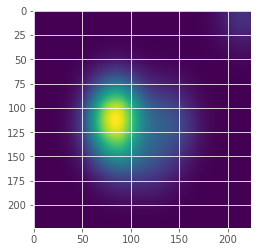

In [174]:
plt.imshow(human_heatmaps_values[0])

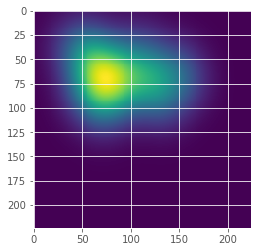

In [175]:
plt.imshow(human_heatmaps_values[10])


  0%|          | 0/614 [00:00<?, ?it/s]

aeroplane_2011_001962.jpg
aeroplane 0.99983037
boat 0.00010107423
dog 1.9047477e-05
motorbike 1.7029686e-05
bicycle 1.4523885e-05
diningtable 1.4226935e-05
horse 3.435414e-06
cat 8.5918494e-08
sofa 7.751303e-08
cow 5.721757e-08
Visualizing for aeroplane
Prediction aeroplane



  0%|          | 1/614 [00:00<04:00,  2.55it/s]

aeroplane 0.99983037
boat 0.00010107423
dog 1.9047477e-05
motorbike 1.7029686e-05
bicycle 1.4523885e-05
diningtable 1.4226935e-05
horse 3.435414e-06
cat 8.5918494e-08
sofa 7.751303e-08
cow 5.721757e-08
Visualizing for boat
Prediction aeroplane
aeroplane 0.99983037
boat 0.00010107423
dog 1.9047477e-05
motorbike 1.7029686e-05
bicycle 1.4523885e-05
diningtable 1.4226935e-05
horse 3.435414e-06
cat 8.5918494e-08
sofa 7.751303e-08
cow 5.721757e-08
Visualizing for aeroplane
Prediction aeroplane
aeroplane_2008_006109.jpg
aeroplane 0.89982665
dog 0.041474823
bicycle 0.029067736
cat 0.012696071
horse 0.010110083
boat 0.0015485532
motorbike 0.0015231029
cow 0.0014675193
diningtable 0.0012454467
sofa 0.0010400584
Visualizing for aeroplane
Prediction aeroplane
aeroplane 0.89982665
dog 0.041474823
bicycle 0.029067736
cat 0.012696071
horse 0.010110083
boat 0.0015485532
motorbike 0.0015231029
cow 0.0014675193
diningtable 0.0012454467
sofa 0.0010400584
Visualizing for dog
Prediction aeroplane



  0%|          | 2/614 [00:00<03:56,  2.58it/s]

aeroplane 0.89982665
dog 0.041474823
bicycle 0.029067736
cat 0.012696071
horse 0.010110083
boat 0.0015485532
motorbike 0.0015231029
cow 0.0014675193
diningtable 0.0012454467
sofa 0.0010400584
Visualizing for aeroplane
Prediction aeroplane
aeroplane_2011_002993.jpg
aeroplane 0.99420834
cat 0.002379377
dog 0.0011357393
motorbike 0.0007023247
horse 0.00049112155
bicycle 0.00046220337
boat 0.00041199708
cow 0.00016274572
sofa 3.3038392e-05
diningtable 1.3082156e-05
Visualizing for aeroplane
Prediction aeroplane



  0%|          | 3/614 [00:01<03:55,  2.60it/s]

aeroplane 0.99420834
cat 0.002379377
dog 0.0011357393
motorbike 0.0007023247
horse 0.00049112155
bicycle 0.00046220337
boat 0.00041199708
cow 0.00016274572
sofa 3.3038392e-05
diningtable 1.3082156e-05
Visualizing for cat
Prediction aeroplane
aeroplane 0.99420834
cat 0.002379377
dog 0.0011357393
motorbike 0.0007023247
horse 0.00049112155
bicycle 0.00046220337
boat 0.00041199708
cow 0.00016274572
sofa 3.3038392e-05
diningtable 1.3082156e-05
Visualizing for aeroplane
Prediction aeroplane
aeroplane_2009_002047.jpg
aeroplane 0.99997497
horse 2.3622879e-05
dog 1.1223553e-06
motorbike 1.7295018e-07
cow 8.876508e-08
bicycle 2.5130875e-08
boat 2.2218268e-08
sofa 1.283089e-09
diningtable 3.7578077e-10
cat 1.7070123e-10
Visualizing for aeroplane
Prediction aeroplane
aeroplane 0.99997497
horse 2.3622879e-05
dog 1.1223553e-06
motorbike 1.7295018e-07
cow 8.876508e-08
bicycle 2.5130875e-08
boat 2.2218268e-08
sofa 1.283089e-09
diningtable 3.7578077e-10
cat 1.7070123e-10
Visualizing for horse
Predictio


  1%|          | 4/614 [00:01<03:53,  2.62it/s]

aeroplane 0.99997497
horse 2.3622879e-05
dog 1.1223553e-06
motorbike 1.7295018e-07
cow 8.876508e-08
bicycle 2.5130875e-08
boat 2.2218268e-08
sofa 1.283089e-09
diningtable 3.7578077e-10
cat 1.7070123e-10
Visualizing for aeroplane
Prediction aeroplane
aeroplane_2009_001372.jpg
aeroplane 0.99991405
cow 6.595811e-05
horse 8.790607e-06
boat 7.865239e-06
bicycle 2.876155e-06
motorbike 2.6245806e-07
dog 1.6069328e-07
cat 4.694484e-08
diningtable 4.0495003e-08
sofa 1.4103034e-08
Visualizing for aeroplane
Prediction aeroplane



  1%|          | 5/614 [00:01<03:49,  2.65it/s]

aeroplane 0.99991405
cow 6.595811e-05
horse 8.790607e-06
boat 7.865239e-06
bicycle 2.876155e-06
motorbike 2.6245806e-07
dog 1.6069328e-07
cat 4.694484e-08
diningtable 4.0495003e-08
sofa 1.4103034e-08
Visualizing for cow
Prediction aeroplane
aeroplane 0.99991405
cow 6.595811e-05
horse 8.790607e-06
boat 7.865239e-06
bicycle 2.876155e-06
motorbike 2.6245806e-07
dog 1.6069328e-07
cat 4.694484e-08
diningtable 4.0495003e-08
sofa 1.4103034e-08
Visualizing for aeroplane
Prediction aeroplane
aeroplane_2008_005078.jpg


aeroplane 0.99999976
cow 1.4562937e-07
boat 8.983129e-08
motorbike 1.6145502e-09
horse 2.2390541e-10
diningtable 4.0323522e-11
sofa 1.3366426e-11
dog 3.940384e-12
bicycle 2.6401407e-12
cat 1.4544328e-12
Visualizing for aeroplane
Prediction aeroplane


KeyboardInterrupt: 

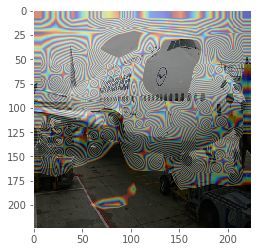

In [260]:
def pearson(a, b):
    return scipy.stats.pearsonr(a.reshape(-1,), b.reshape(-1,))[0]

def construct_name(class_name, file_id):
    return class_name + '_' + str(file_id) + '.jpg'

def overlay_heatmap(org_img, heatmap, gauss_sigma=None, thresh=None, normalize=False, absolute=False):
    img = org_img/255
    if absolute:
        heatmap = np.abs(heatmap)
    
    if thresh:
        heatmap[heatmap < thresh] = 0
    
    if normalize:
        heatmap = utils.normalize(heatmap)
        
#     print(np.min(heatmap), np.max(heatmap))
    if gauss_sigma is not None:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma=gauss_sigma)
    
    if not normalize:
        heatmap = heatmap / 40
    
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    
    if normalize:
        pass
    else:
        if absolute:
            plt.clim(0,1)
        else:
            plt.clim(-1,1)
    
    colorbar = plt.colorbar()
#     print(colorbar)
#     plt.show()
    
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.5
    

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img, colorbar

results = {}
def construct_res(image, ground_truth, first, second, correct, prob_res):
    def get_hm_dict(gt, hm):
        return{
            'hm': hm,
            'pcc': pearson(np.abs(hm), gt)
        }
    return {
        'image': image,
        'ground_truth': get_hm_dict(ground_truth, ground_truth),
        'first_prob': get_hm_dict(ground_truth, first),
        'second_prob': get_hm_dict(ground_truth, second),
        'correct': get_hm_dict(ground_truth, correct),
        'prob_res': prob_res
    }

for sample_n in tqdm(range(X_test.shape[0])):
    name = names[sample_n]
    # name = correct_names[sample_n]
    print(name)

    image = get_image(X_test, names, name)
    ground_truth_heatmap = human_heatmaps[name].copy()

#     plt.imshow(utils.normalize(image))
#     plt.grid(False)
#     plt.show()

    first, prob_res = visualize_class_activation_map(model=model, 
                                       original_img=image, 
                                       output_path='poet0.jpg', class_map=class_map, 
                                       visualize_for_class=None, cam_thresh=0.)
#     print("Pearson", pearson(np.abs(heatmap), ground_truth_heatmap))

#     img, colorbar = overlay_heatmap(org_img, heatmap, absolute=True)
#     plt.imshow(img, cmap='jet')
#     # plt.colorbar()
#     frame1 = plt.gca()
#     frame1.axes.xaxis.set_ticks([])
#     frame1.axes.yaxis.set_ticks([])
# #     plt.show()

    second, prob_res = visualize_class_activation_map(model=model, 
                                       original_img=image, 
                                       output_path='poet0.jpg', class_map=class_map, 
                                       visualize_for_class='second', cam_thresh=0.)
#     print("Pearson", pearson(np.abs(heatmap), ground_truth_heatmap))

#     img, colorbar = overlay_heatmap(org_img, heatmap, absolute=True)
#     plt.imshow(img, cmap='jet')
#     # plt.colorbar()
#     plt.show()

    correct, prob_res = visualize_class_activation_map(model=model, 
                                       original_img=image, 
                                       output_path='poet0.jpg', class_map=class_map, 
                                       visualize_for_class=name.split('_')[0], cam_thresh=0.)
#     print("Pearson", pearson(heatmap, ground_truth_heatmap))

#     img, colorbar = overlay_heatmap(org_img, heatmap, absolute=True)
#     plt.imshow(img, cmap='jet')
#     # plt.colorbar()
# #     plt.show()

#     plt.imshow(ground_truth_heatmap, cmap='jet')
#     # plt.colorbar()
# #     plt.show()

#     img, colorbar = overlay_heatmap(org_img, ground_truth_heatmap, thresh=None, normalize=True)
#     plt.imshow(img)
#     # plt.colorbar()
#     plt.grid(False)
#     plt.show()
    results[name] = construct_res(image, ground_truth_heatmap, first ,second ,correct, prob_res)

In [12]:
hm_test = utils.load_object('cam_heatmaps_test.pkl')
class_map = utils.load_object('cam_classmap.pkl')

In [262]:
a = hm_test[name]['ground_truth']['hm']

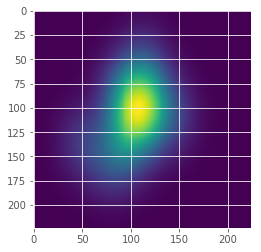

In [263]:
plt.imshow(a)

Prediction results:
aeroplane 0.89982665
dog 0.041474823
bicycle 0.029067736
cat 0.012696071
horse 0.010110083
boat 0.0015485532
motorbike 0.0015231029
cow 0.0014675193
diningtable 0.0012454467
sofa 0.0010400584


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


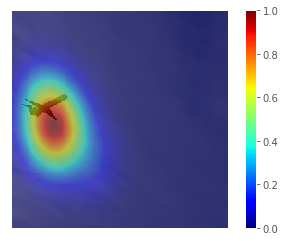

Perason correlation with ground truth: 1.0


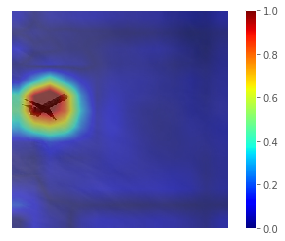

Prediction: aeroplane
Perason correlation with ground truth: 0.7497286238212234


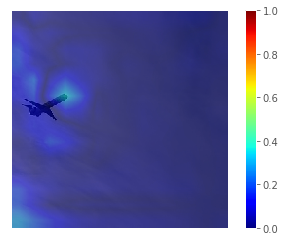

Prediction: dog
Perason correlation with ground truth: 0.42696168270536244


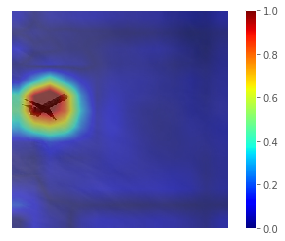

Prediction: aeroplane
Perason correlation with ground truth: 0.7497286238212234


In [264]:
name = list(hm_test.keys())[1]

keys_to_vis = ['ground_truth', 'first_prob', 'second_prob', 'correct']

def visualize(name, heatmap_results_list, class_map):    
    hm_results = heatmap_results_list[name]
    print("Prediction results:")
    print_proba_results(hm_results['prob_res'], inv_class_map)
    
    for key in keys_to_vis:
        hm_result = hm_results[key]
        img, colorbar = overlay_heatmap(hm_results['image'], hm_result['hm'], 
                                        normalize=(key == 'ground_truth'), absolute=True)
        plt.imshow(img, cmap='jet')
        # plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()
        if key == 'first_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][0][0]])
        elif key == 'second_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][1][0]])
        elif key == 'correct':
            for res in hm_results['prob_res']:
                class_n, prob = res
                if inv_class_map[class_n] == name.split('_')[0]:
                    print("Prediction:", inv_class_map[class_n])
        
        print("Perason correlation with ground truth:", hm_result['pcc'])
    
visualize(name, hm_test, class_map)

## org_img.shape

In [30]:
def screen_area(deg):
    return 0.6 * np.tan(np.deg2rad(deg))

def pixels(deg):
    return screen_area(deg) / (0.28 / 10 / 100)

pixel_size = 0.28 / 10 / 100

screen_area(2.5) / pixel_size, screen_area(5) / pixel_size, screen_area(10) / pixel_size, pixels(10)

(93.55916337538297, 187.47570755555142, 377.84353008956776, 377.84353008956776)

In [38]:
def makeGaussian(size, fwhm = 3, center=None):
    #https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    std = fwhm / 2.355
    print(std)
    print(std**2)
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

(90 / 2.355)**2

1460.5054971804132

In [149]:
pixels(2.5)

93.55916337538297

39.727882537317605
1578.304650898905


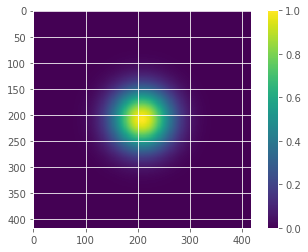

In [49]:
plt.imshow(makeGaussian(pixels(11), pixels(2.5)))
plt.colorbar()

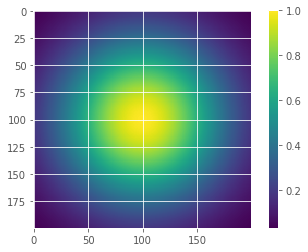

In [11]:
plt.imshow(makeGaussian(200, (7/11)*200))
plt.colorbar()

In [348]:
(screen_area(10) / pixel_size) / 800

0.4723044126119597

In [372]:
a = scipy.signal.convolve2d(list(human_heatmaps.values())[0], makeGaussian(200, (7/11)*200), mode='same')

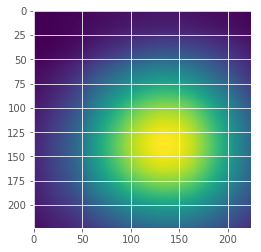

In [373]:
plt.imshow(a)

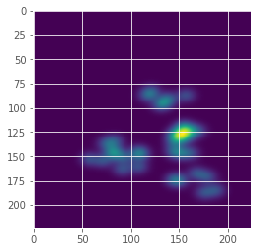

In [460]:
plt.imshow(list(human_heatmaps.values())[100])

In [451]:
image_max = scipy.ndimage.maximum_filter(list(human_heatmaps.values())[1], size=10, mode='constant')

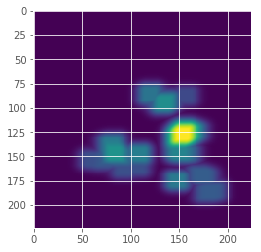

In [452]:
plt.imshow(image_max)